In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
data.shape
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#read in X and Y as numpy arrays
X = np.array(data)
Y = np.array(data)
X = X[:,1:]
Y = Y[:,0]
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

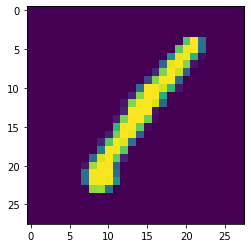

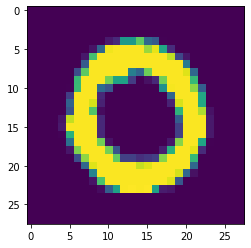

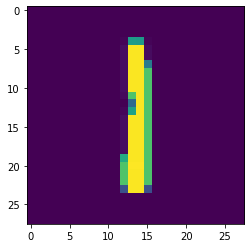

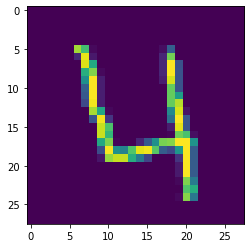

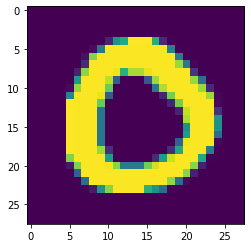

In [7]:
#reshape rows of X into 28 x 28 2D arrays
img1 = np.reshape(X[0],(28,28))
img2 = np.reshape(X[1],(28,28))
img3 = np.reshape(X[2],(28,28))
img4 = np.reshape(X[3],(28,28))
img5 = np.reshape(X[4],(28,28))

#visualise 5 images
imgplot = plt.imshow(img1)
plt.show()
imgplot = plt.imshow(img2)
plt.show()
imgplot = plt.imshow(img3)
plt.show()
imgplot = plt.imshow(img4)
plt.show()
imgplot = plt.imshow(img5)
plt.show()

In [20]:
#get tensors
Xtensor = torch.from_numpy(X).type(torch.float)
Ytensor = torch.from_numpy(Y)

#split into training and validation
X_train, X_validation, Y_train, Y_validation = Xtensor[:33600],Xtensor[33600:], Ytensor[:33600],Ytensor[33600:]

#move tensors onto GPU
X_train, X_validation, Y_train, Y_validation = X_train.to(device), X_validation.to(device), Y_train.to(device), Y_validation.to(device)
print(X_train.shape)
print(X_validation.shape)
print(Y_validation.shape)
print(Y_train.shape)


torch.Size([33600, 784])
torch.Size([8400, 784])
torch.Size([8400])
torch.Size([33600])


In [21]:
#create Autoencoder
class Autoencoder(nn.Module): 
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #encodes 
        self.encoder = nn.Sequential(
            nn.Linear(784,128,True),
            nn.ReLU(),
            nn.Linear(128, 64, True),
            nn.ReLU(),
            nn.Linear(64,36,True),
            nn.ReLU(),
            nn.Linear(36,18,True),
            nn.ReLU(),
            nn.Linear(18, 9, True)
        )
        
        #decodes
        self.decoder = nn.Sequential(
            nn.Linear(9,18,True),
            nn.ReLU(),
            nn.Linear(18, 36, True),
            nn.ReLU(),
            nn.Linear(36,64,True),
            nn.ReLU(),
            nn.Linear(64,128,True),
            nn.ReLU(),
            nn.Linear(128, 784, True)
        )
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
Autoencoder = Autoencoder() 
Autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
  )
)

In [22]:
#training the model for x epochs

criterion = nn.MSELoss()
optimiser = optim.Adam(Autoencoder.parameters())
epochs = 1000
outputs = []
training_loss = []
validation_loss = []

for x in tqdm(range(0,epochs), desc = "Epoch No.:"):
    Autoencoder.zero_grad()
    output = Autoencoder(X_train)
    loss = criterion(output,X_train)
    training_loss.append(loss.item())
    loss.backward()
    optimiser.step()
    with torch.no_grad(): 
        output = Autoencoder(X_validation)
        loss = criterion(output, X_validation)
        validation_loss.append(loss.item())

Epoch No.:: 100%|██████████| 1000/1000 [00:13<00:00, 74.42it/s]


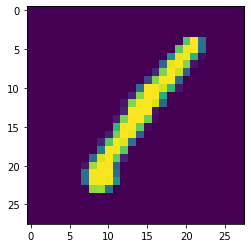

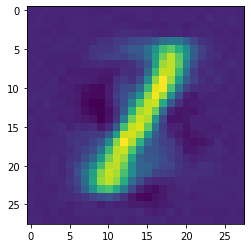

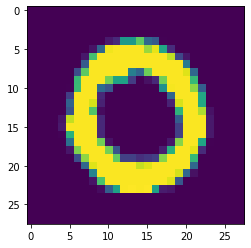

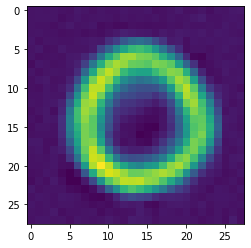

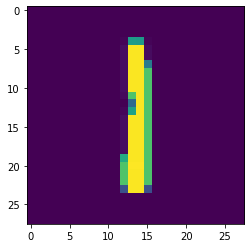

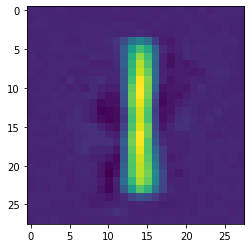

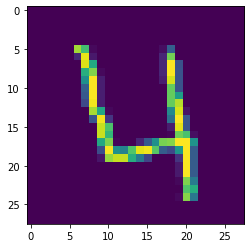

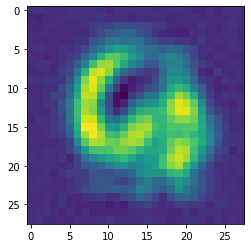

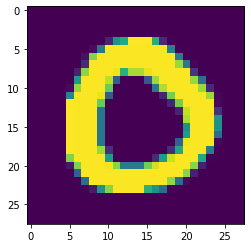

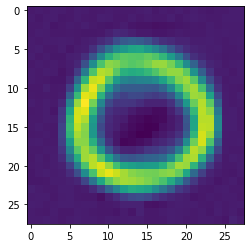

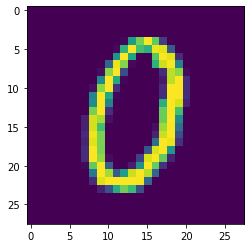

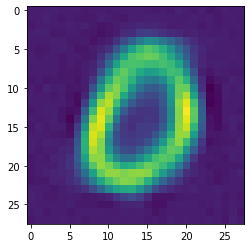

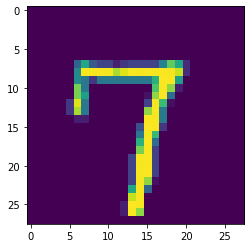

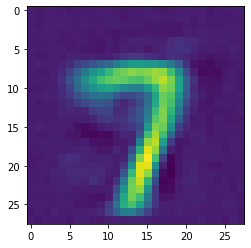

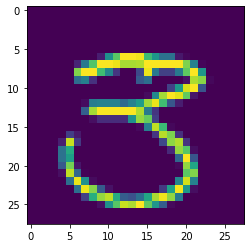

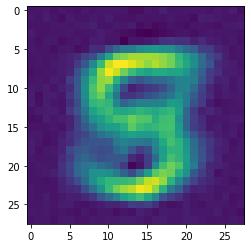

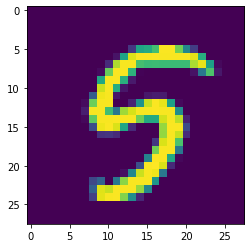

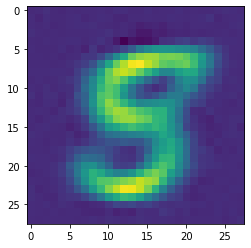

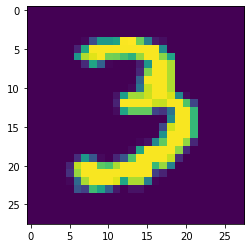

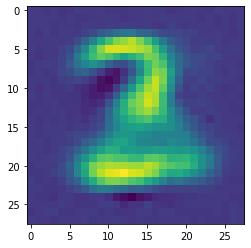

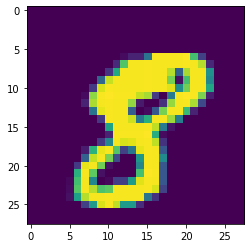

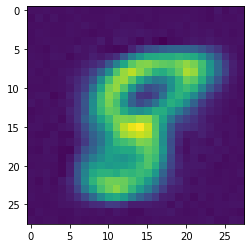

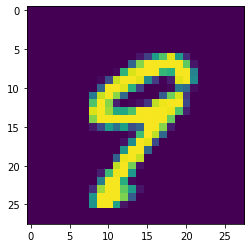

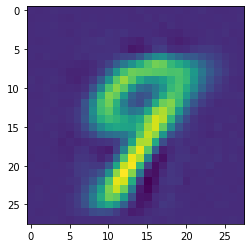

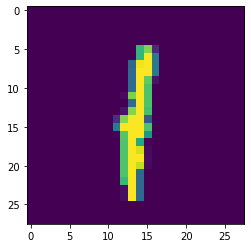

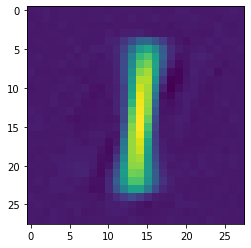

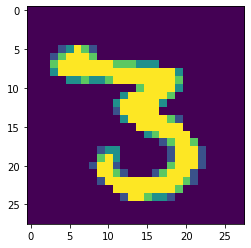

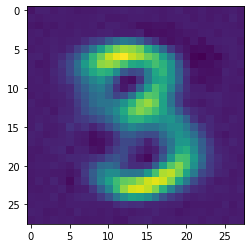

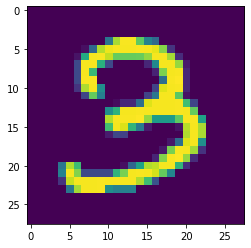

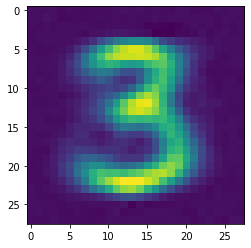

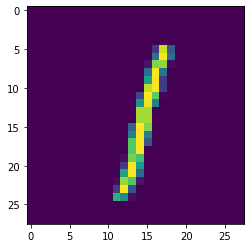

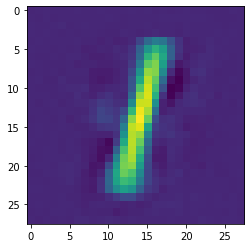

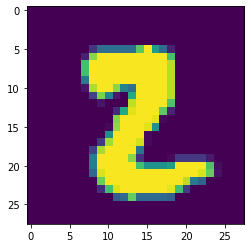

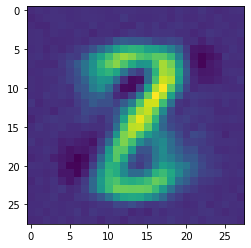

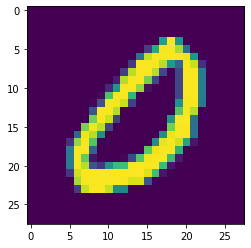

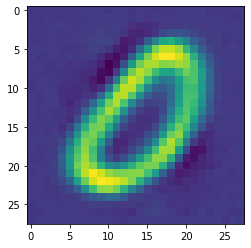

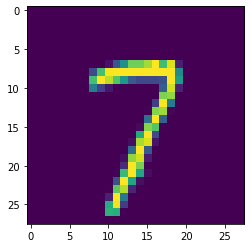

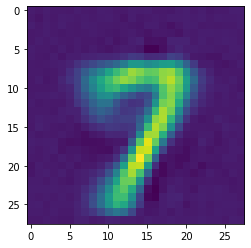

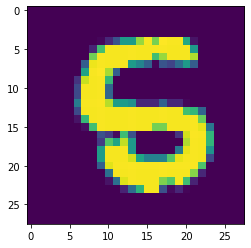

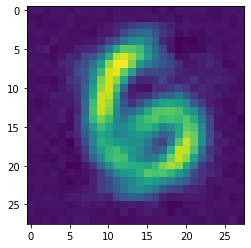

In [23]:
def Display(X_train):
    for x in range(20):
        #running the autoencoder on a sample
        plt.imshow(X_train[x].to("cpu").detach().numpy().reshape(28,28))
        plt.show()
        cur = Autoencoder(X_train[x])
        
        #moving tensor from GPU to CPU
        cur = cur.to("cpu")
        
        #detaching tensor --> converting to numpy
        cur = cur.detach().numpy()
        
        #reshaping array to display
        cur = cur.reshape(28,28)
        
        #display image
        plt.imshow(cur)
        plt.show()

Display(X_train)

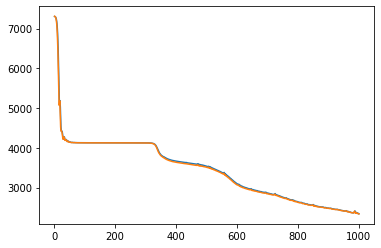

In [27]:
#visualising training and validation loss
plt.plot([x for x in range(1,1001)],training_loss)
plt.plot([x for x in range(1,1001)],validation_loss)

949


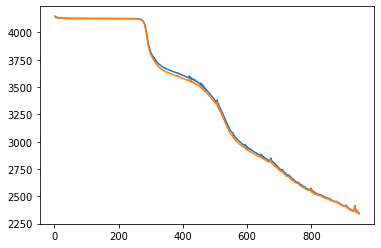

In [28]:
loss_wout_50_t = training_loss[51:]
loss_wout_50_v = validation_loss[51:]
print(len(loss_wout_50_t))
plt.plot([x for x in range(1,950)],loss_wout_50_t)
plt.plot([x for x in range(1,950)],loss_wout_50_v)